In [83]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import sklearn as skl
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler


In [84]:
ticker = 'INX'

In [85]:
ts = TimeSeries(key='AJH8MF4OQ465LD6H',output_format='pandas')
data, meta_data = ts.get_daily(symbol='INX', outputsize='full')


In [86]:
data = data.sort_values(by = 'date')
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2000-01-03,1469.2500,1478.0000,1438.3600,1455.2200,9.318000e+08
2000-01-04,1455.2200,1455.2200,1397.4301,1399.4200,1.009000e+09
2000-01-05,1399.4200,1413.2700,1377.6801,1402.1100,1.085500e+09
2000-01-06,1402.1100,1411.9000,1392.1000,1403.4500,1.092300e+09
2000-01-07,1403.4500,1441.4700,1400.7300,1441.4700,1.225200e+09
...,...,...,...,...,...
2020-03-19,2483.1621,2484.9523,2469.0456,2470.9382,2.037970e+05
2020-03-20,2470.9382,2478.3314,2454.4354,2472.7356,3.250400e+04
2020-03-23,2472.7356,2480.4663,2463.9532,2465.9066,7.508570e+05


In [87]:
#Create a new dataframe for open price
data = data.filter(['1. open'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = int( len(dataset) * .8 )

training_data_len

4071

In [88]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.34753743],
       [0.34136511],
       [0.3168166 ],
       ...,
       [0.78900839],
       [0.78600406],
       [0.78242446]])

In [6]:
#Create and scale the training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
X_train = []
y_train = []

for i in range(50, len(train_data)):
  X_train.append(train_data[i-50:i, 0])
  y_train.append(train_data[i, 0])

In [7]:
train_data

array([[0.29245475],
       [0.28726071],
       [0.26660299],
       ...,
       [0.48028077],
       [0.48361266],
       [0.48672612]])

In [8]:
#Convert the train data to numpy arrays 
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
#Reshape to 3D from 2D to fit into LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4018, 50, 1)

In [10]:
#Define Model
model = Sequential()

#input later
model.add(LSTM(15, return_sequences=True, input_shape= (X_train.shape[1], 1)))

#second layer
model.add(LSTM(10, return_sequences= False))

#third
model.add(Dense(5))

#Output
model.add(Dense(1))


#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:

#Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
4018/4018 [==============================] - 313s 78ms/step - loss: 4.5850e-04


In [50]:
#Test the model
test_data = scaled_data[training_data_len - 50: , :]
#Create the data sets x_test and y_test
X_test = []
y_test = dataset[training_data_len:, :]
for i in range(50, len(test_data)):
  X_test.append(test_data[i-50:i, 0])
#Convert the data to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

In [51]:
#Get the models predicted price values 
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


In [68]:
# we added this -1, to grab just the "last day" 5031; because we only want one predicted 5032nd day's open price
concatenated_prices = X_test[-1:, :, :]
next_day_prediction = model.predict(concatenated_prices)
how_many_days_in_the_future = 7
prediction_for_days_in_future = []# next_day_prediction[0][0]]
for i in range(how_many_days_in_the_future):
    concatenated_prices = np.concatenate([
        #------------------------------v we slice *off* the 50 days ago value; so we only have 49 days of data;
        concatenated_prices[-1:, 1:, :], 
        # Add in the new predicted value
        np.expand_dims(next_day_prediction, -1)
    ], axis=1)
    # Therefore we can predict last day
    next_day_prediction = model.predict(concatenated_prices)
    #Appending onto the list (1D) the [0][0]th value of a 2D array; so we have a list of predicted values in the future
    prediction_for_days_in_future.append(next_day_prediction[0][0])
# inverse_transform them 
week_prediction = scaler.inverse_transform(np.expand_dims(prediction_for_days_in_future, -1))

In [69]:
week_prediction = pd.DataFrame(week_prediction,columns=['One week of Predicted Prices'])

,One week of Predicted Prices
0,2598.992920
1,2580.958008
2,2567.802246
3,2557.883545
4,2550.127197
5,2543.830811
6,2538.532227


/Users/jaychung/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


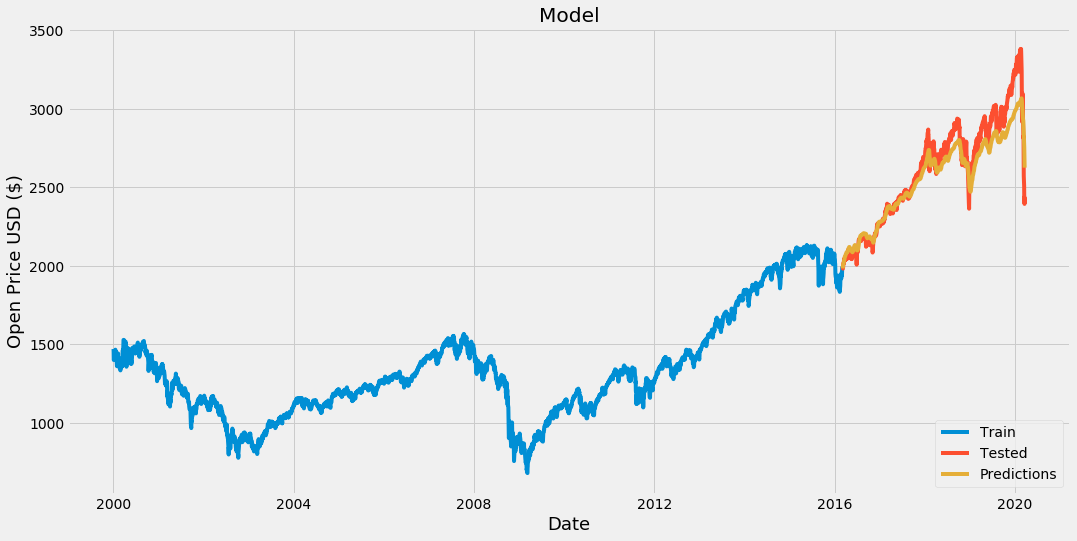

In [60]:
#Plot the data
train = data[:training_data_len]
tested = data[training_data_len:]
tested['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['1. open'])
plt.plot(tested[['1. open', 'Predictions']])
plt.legend(['Train', 'Tested', 'Predictions'], loc='lower right')
plt.show()

In [91]:
pd.DataFrame(data).to_csv('actual_INX.csv')
pd.DataFrame(predictions).to_csv('predicted_INX.csv')
pd.DataFrame(week_prediction).to_csv('future_INX.csv')